# Importing Libraries

In [3]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance,variance_decomposition_ex_post
from PnL_Computation import PnL
from Stock_Data import get_close
from Rebalancing import *
from Git import *

In [4]:
git=GitHub(token,repo_owner,repo_name,branch)
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

# Loading Benchmark

In [6]:
start_date=datetime.datetime(2020,1,1)
today=datetime.datetime.today()
days=(today-start_date).days
remaining=days%500
numbers_of_table=days//500
tickers=Binance.get_market_cap()['Ticker'].iloc[:40].to_list()
temp_end=start_date
scope_prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    scope_prices=scope_prices.combine_first(data)
    
temp_end=(today-datetime.timedelta(remaining))
data=Binance.get_price(tickers,temp_end)
scope_prices=scope_prices.combine_first(data)
scope_prices=scope_prices.sort_index()
scope_prices = scope_prices[~scope_prices.index.duplicated(keep='first')]
scope_prices.index=pd.to_datetime(scope_prices.index)
tickers2=Binance.get_market_cap()['Ticker'].iloc[:20].to_list()
prices=scope_prices[tickers2]
returns=np.log(1+prices.pct_change(fill_method=None))
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na].sort_index()
dataframe=prices[with_no_na].sort_index()
dataframe.index=pd.to_datetime(dataframe.index)
returns_to_use.index=pd.to_datetime(returns_to_use.index)
returns_to_use = returns_to_use[~returns_to_use.index.duplicated(keep='first')]

month=list(sorted(set(returns_to_use.index + pd.offsets.BMonthEnd(0))))
#month_end=pd.to_datetime(mrat_wo_na.index)
month = pd.to_datetime(month)

idx1 = pd.Index(returns_to_use.iloc[:-1].index)
idx2 = pd.Index(month)
closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]

dates_end=list(closest_dates)
dates_end.insert(0,returns_to_use.index[1])
dates_end.append(returns_to_use.index[-1])
dates_end=sorted(list(set(dates_end)))
dates_end.pop(0)
dates_end=sorted(list(set(dates_end)))

results={}

if 'USDCUSDT' in returns_to_use.columns:
    
    cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

else:

    cash=[]
# gold_positions=np.where(returns_to_use.columns=='GOLD.PA')[0][0]
#om_limit=np.where(returns_to_use.columns=='OMUSDT')[0][0]

for i in range(len(dates_end)-1):
    
    try:
        dataset=returns_to_use.loc[dates_end[i]:dates_end[i+1]]        
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        
        optimal=risk.optimize(objective='minimum_variance',constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00}#,
                                                                       ])# {'type': 'eq', 'fun': lambda weights: weights[gold_positions]-0.00}])
        
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
        pass

rolling_optimization=pd.DataFrame(results,index=dataframe.columns).T
rolling_optimization.loc[dates_end[0]]=1/len(dataframe.columns)
rolling_optimization=rolling_optimization.sort_index()

performance_model=pd.DataFrame()

In [7]:
q=rebalanced_dynamic_quantities(dataframe,rolling_optimization.iloc[:-2])
results=q*dataframe

performance_model['Fund']=results.sum(axis=1)
performance_model['Bitcoin']=dataframe['BTCUSDT']
#performance['Mantra']=dataframe['OMUSDT']

performance_model_pct=performance_model.copy()
performance_model_pct=performance_model_pct.pct_change(fill_method=None)

# Importing Data

In [9]:
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [10]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [12]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [13]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [14]:
quantities_api=Binance.binance_api.user_asset()

current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [15]:
# trade_history=pd.read_excel('Trades USDT.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))

In [16]:
price=Pnl_calculation.get_trade_in_usdt(trade_history)

TRXUSDT 0
BTCUSDT 1
TRXUSDT 2
BNBUSDT 3
ETHUSDT 4
SOLUSDT 5
BNBUSDT 6
USDTTRY 7
JASMYUSDT 8
BNBUSDT 9
BBUSDT 10
USDTTRY 11
BNBUSDT 12
USDTTRY 13
TRXUSDT 14
USDTTRY 15
JASMYUSDT 16
BNBUSDT 17
BBUSDT 18
OMUSDT 19
OMUSDT 20
OMUSDT 21
TRXUSDT 22
BTCUSDT 23
OMUSDT 24
BTCUSDT 25
TRXUSDT 26
TRXUSDT 27
BBUSDT 28
BNBUSDT 29
TRXUSDT 30
BTCUSDT 31
TRXUSDT 32
BTCUSDT 33
MKRUSDT 34
BTCUSDT 35
MKRUSDT 36
EURUSDT 37
EURUSDT 38
BBUSDT 39
BNBUSDT 40
JASMYUSDT 41
PEPEUSDT 42
NOTUSDT 43
NOTUSDT 44
NOTUSDT 45
BBUSDT 46
BBUSDT 47
PEPEUSDT 48
JASMYUSDT 49
BTCUSDT 50
BTCUSDT 51
TRXUSDT 52
BTCUSDT 53
BNBUSDT 54
BTCUSDT 55
BNBUSDT 56
BTCUSDT 57
BNBUSDT 58
BTCUSDT 59
BNBUSDT 60
BTCUSDT 61
BNBUSDT 62
BNBUSDT 63
BTCUSDT 64
BNBUSDT 65
JASMYUSDT 66
JASMYUSDT 67
ENSUSDT 68
ARUSDT 69
BTCUSDT 70
UMAUSDT 71
BTCUSDT 72
UMAUSDT 73
ETHUSDT 74
XRPUSDT 75
BTCUSDT 76
XRPUSDT 77
BTCUSDT 78
NEARUSDT 79
BTCUSDT 80
LPTUSDT 81
BTCUSDT 82
NEARUSDT 83
EURUSDT 84
BTCUSDT 85
INJUSDT 86
BTCUSDT 87
FETUSDT 88
EURUSDT 89
EURUSDT 90
EURU

In [17]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

historical_positions.rename(columns={'TRYUSDT': 'USDTTRY'}, inplace=True)

In [18]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_332392\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [19]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()


In [20]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:80].to_list()

In [21]:
holding=Binance.get_inventory()
last_prices=Binance.get_price(list(q.iloc[-1].keys()))

positions=pd.DataFrame(q.iloc[-1]*last_prices).T
positions['Weights Model']=positions[positions.columns]/positions[positions.columns].sum()

condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
holding_tickers.remove("USDCUSDT")
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,last_book_cost,holding.loc[condition],positions['Weights Model'],realized_pnl],axis=1)
pnl.columns=['Average Cost','Book Cost','Price in USDT','Weights','Weights Model','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Average Cost']=np.nan

pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100
pnl.sort_values(by='Weights',ascending=False).round(4)

,Average Cost,Book Cost,Price in USDT,Weights,Weights Model,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,NaN,2085.7390,2085.6506,0.9999,1.0000,-121.1884,121.10,-0.0884,-0.0042
TRXUSDT,0.2647,872.3899,1110.2837,0.5323,0.5739,-12.2962,237.89,225.5938,10.8160
BTCUSDT,68795.5284,565.5529,898.5503,0.4308,0.4261,13.0697,333.00,346.0697,16.5922
OMUSDT,1.1299,526.3213,76.4852,0.0367,0.0000,0.0000,-449.84,-449.8400,-21.5674
ETHUSDT,3654.5327,0.1328,0.1458,0.0001,0.0000,55.9949,0.01,56.0049,2.6851
FETUSDT,2.2929,0.0000,0.0000,0.0000,0.0000,0.0088,0.00,0.0088,0.0004
JASMYUSDT,0.0303,0.0000,0.0000,0.0000,0.0000,-172.9781,0.00,-172.9781,-8.2934
UMAUSDT,4.0983,0.0000,0.0000,0.0000,0.0000,-5.0186,0.00,-5.0186,-0.2406
NOTUSDT,0.0196,0.0000,0.0000,0.0000,0.0000,1.0078,0.00,1.0078,0.0483
USDCUSDT,0.0000,0.0000,0.0332,0.0000,0.0000,0.0000,0.00,0.0000,0.0000


In [22]:
selling_amount=pd.DataFrame()

selling_amount['Portfolio']=pnl['Weights']
selling_amount['Model']=pnl['Weights Model']
selling_amount['Positions']=pnl['Price in USDT']

selling_amount['Model Positions']=selling_amount['Model']*selling_amount.loc['Total','Positions']
selling_amount['Spread']=selling_amount['Model Positions']-selling_amount['Positions']
selling_amount.sort_values(by='Model',ascending=False).round(2)

,Portfolio,Model,Positions,Model Positions,Spread
Total,1.00,1.00,2085.65,2085.65,0.00
TRXUSDT,0.53,0.57,1110.28,1196.85,86.57
BTCUSDT,0.43,0.43,898.55,888.80,-9.75
MKRUSDT,0.00,0.00,0.00,0.00,0.00
BCHUSDT,0.00,0.00,0.00,0.00,0.00
XLMUSDT,0.00,0.00,0.00,0.00,0.00
LINKUSDT,0.00,0.00,0.00,0.00,0.00
ADAUSDT,0.00,0.00,0.00,0.00,0.00
DOGEUSDT,0.00,0.00,0.00,0.00,0.00
USDCUSDT,0.00,0.00,0.03,0.00,-0.03


In [23]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [24]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [25]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [26]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')
inventory_weights.pop('USDCUSDT')


if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [27]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [28]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [30]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: 1329ac618d85364c386079f6c0f758f352457560)
✅ File pushed/updated successfully!


In [31]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [32]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [33]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [34]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: 3ea986e5a4e79c8e6d301cfee7b7db6880f2bcb9)
✅ File pushed/updated successfully!


In [35]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [36]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [37]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()
cols=quantities.columns[quantities.columns!='USDCUSDT']

for col in cols:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index] 

In [38]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [39]:
# pnl_history['Total']

In [40]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [41]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [42]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [43]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in cols:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [44]:
pnl_history['Total']

2024-09-23   -247.226270
2024-09-24   -303.288508
2024-09-25   -320.535015
2024-09-26   -234.835798
2024-09-27   -218.316677
                 ...    
2025-09-22   -161.554918
2025-09-23   -181.961419
2025-09-24   -164.237190
2025-09-25   -226.157590
2025-09-26    128.806336
Name: Total, Length: 369, dtype: float64

<Axes: >

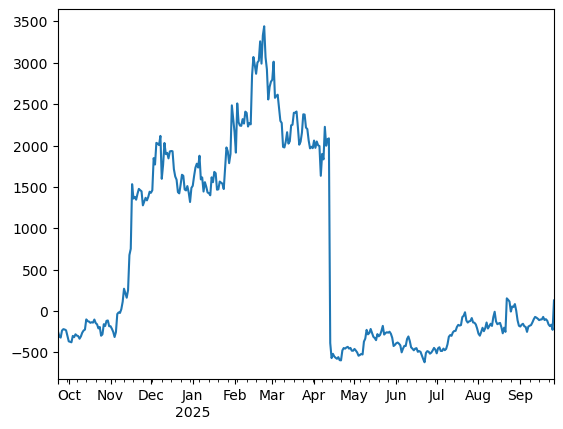

In [45]:
pnl_history['Total'].plot()

In [46]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl[-31:]

2025-08-27     -5.984666
2025-08-28     34.510654
2025-08-29    -80.680751
2025-08-30   -116.557176
2025-08-31    -64.917376
2025-09-01     -9.128634
2025-09-02     21.807289
2025-09-03     11.513615
2025-09-04    -30.406007
2025-09-05     -7.870188
2025-09-06    -59.574293
2025-09-07     64.103747
2025-09-08     10.429624
2025-09-09      7.514311
2025-09-10     32.069894
2025-09-11     38.330067
2025-09-12     28.157845
2025-09-13     -9.210608
2025-09-14    -12.518451
2025-09-15    -17.024334
2025-09-16      7.182172
2025-09-17      1.849051
2025-09-18     29.806058
2025-09-19    -37.805603
2025-09-20     10.375811
2025-09-21    -18.452314
2025-09-22    -45.323121
2025-09-23    -20.406501
2025-09-24     17.724228
2025-09-25    -61.920400
2025-09-26    354.963926
Name: Total, dtype: float64

In [47]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']

var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-367.9072985403869, -950.5160328166937)

In [48]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [49]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [50]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [51]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [52]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [53]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [54]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

In [347]:
variance_decomposition=variance_decomposition_ex_post(quantities.fillna(0).loc['2025-08':],price_pnl.loc['2025-08':])
variance_decomposition_pct=variance_decomposition.copy()
total_var=variance_decomposition['Variance'].sum()
for col in variance_decomposition_pct.columns:
    variance_decomposition_pct[col]=variance_decomposition[col]/total_var

In [349]:
variance_decomposition_pct.round(4)

,Variance,Correlation,Idiosyncratic
BNBUSDT,0.0035,0.0035,0.0001
BTCUSDT,0.2928,0.1367,0.1561
ETHUSDT,0.1718,0.1024,0.0694
OMUSDT,0.0595,0.0458,0.0137
PEPEUSDT,0.0000,0.0000,0.0000
SOLUSDT,0.1883,0.1074,0.0809
TRXUSDT,0.2015,0.0579,0.1436
USDCUSDT,-0.0000,-0.0000,0.0000
BBUSDT,0.0037,0.0031,0.0006
JASMYUSDT,0.0788,0.0502,0.0286


In [57]:

# ptf=(quantities.fillna(0)*price_pnl).dropna()

# weights_ptf = ptf.div(ptf.sum(axis=1), axis=0).loc[ptf.index].to_numpy()

# r = price_pnl.pct_change().fillna(0).loc[ptf.index].to_numpy()
# T = r.shape[0]
# n = r.shape[1]

# r_mean = r.mean(axis=0)
# r_tilde = r - r_mean
# rp_tilde = (weights_ptf * r_tilde).sum(axis=1)

# C_mat = np.zeros((n, n))
# for t in range(T):
#     u = weights_ptf[t] * r_tilde[t]
#     C_mat += np.outer(u, u)

# C_mat /= (T - 1)

# diag_vec = np.diag(C_mat)
# offdiag = C_mat - np.diag(diag_vec)
# idiosyncratic = diag_vec
# correlation = 0.5 * offdiag.sum(axis=1)
# allocated = idiosyncratic + correlation

# results = pd.DataFrame({
#      "Variance": allocated,
#     "Correlation": correlation,
#    "Idiosyncratic": idiosyncratic
# }, index=price_pnl.columns)

# (results/results.sum(axis=0)).round(4)

In [58]:
variance_decomposition_ex_post(quantities.fillna(0),price_pnl)

,Variance,Correlation,Idiosyncratic
BNBUSDT,2.581243e-07,2.551274e-07,2.996895e-09
BTCUSDT,1.016027e-04,5.291525e-05,4.868741e-05
ETHUSDT,3.462543e-05,2.493529e-05,9.690135e-06
OMUSDT,1.028589e-03,6.577149e-05,9.628179e-04
PEPEUSDT,6.429339e-13,6.429339e-13,7.499998e-21
SOLUSDT,6.876267e-05,4.557544e-05,2.318723e-05
TRXUSDT,2.869358e-05,1.346584e-05,1.522774e-05
USDCUSDT,-2.304152e-13,-2.304160e-13,8.412226e-19
BBUSDT,5.479582e-06,5.078130e-06,4.014522e-07
JASMYUSDT,9.902648e-05,4.605195e-05,5.297453e-05


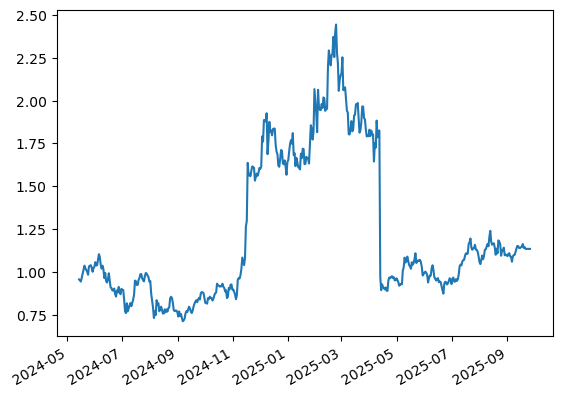

In [59]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()
plt.show()

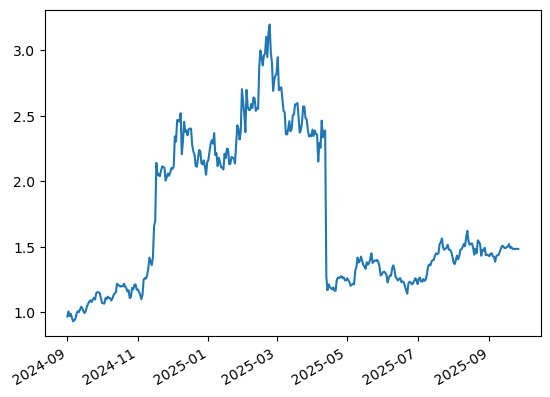

In [60]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()
plt.show()

## Ex ante data

In [62]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [65]:
days=120
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [66]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]#,np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]
gold=np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [69]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00},
                                                                           {'type': 'eq', 'fun': lambda weights: 0.00-weights[gold]}])#,
                                                                              
                                                                              #{'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
BNBUSDT,0.6612
TRXUSDT,0.3388
ETHUSDT,0.0000
ADAUSDT,0.0000
LINKUSDT,0.0000
ALGOUSDT,0.0000
FDUSDUSDT,0.0000
OMUSDT,0.0000
STXUSDT,0.0000
FETUSDT,0.0000


In [70]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.0},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[gold]},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[cash]}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
BNBUSDT,0.661426
TRXUSDT,0.338574


In [71]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))

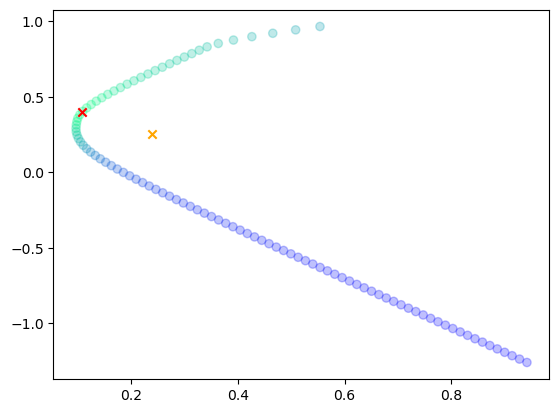

In [72]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [73]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [74]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
TRXUSDT,1110.2837,0.5323,0.0624,0.4699
BTCUSDT,898.5503,0.4308,0.0000,0.4308
OMUSDT,76.4852,0.0367,0.0000,0.0367
ETHUSDT,0.1458,0.0001,0.0000,0.0001
SOLUSDT,0.0894,0.0000,0.0000,0.0000
BNBUSDT,0.0628,0.0000,0.0847,-0.0847
USDCUSDT,0.0332,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0000,0.0000
PAXGUSDT,0.0000,0.0000,0.7059,-0.7059


### Current results

In [76]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

gold_current=np.where(ex_ante_perf_to_use.columns=='PAXGUSDT')[0][0]

In [77]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.00-weights[gold_current]}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BNBUSDT,0.661576
TRXUSDT,0.338424


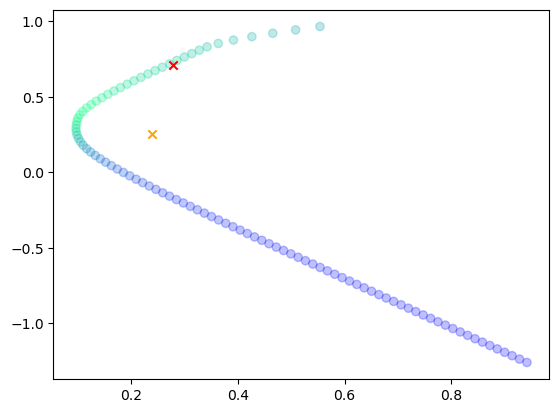

In [78]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [79]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
TRXUSDT,1110.2837,0.5323,0.3384,0.1939
BTCUSDT,898.5503,0.4308,0.0000,0.4308
OMUSDT,76.4852,0.0367,0.0000,0.0367
ETHUSDT,0.1458,0.0001,0.0000,0.0001
SOLUSDT,0.0894,0.0000,0.0000,0.0000
BNBUSDT,0.0628,0.0000,0.6616,-0.6615
USDCUSDT,0.0332,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0000,0.0000


# Risk Reward Analysis

In [81]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [82]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf
portfolio_perf['Model']=performance_model_pct['Fund']

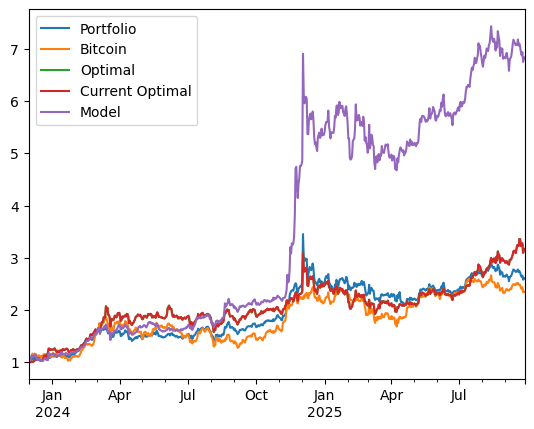

In [83]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [84]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

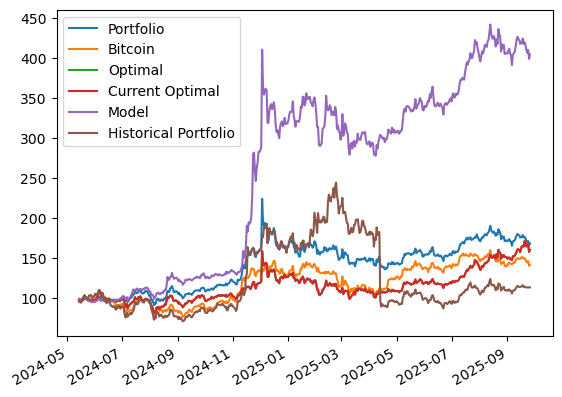

In [85]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


<Axes: >

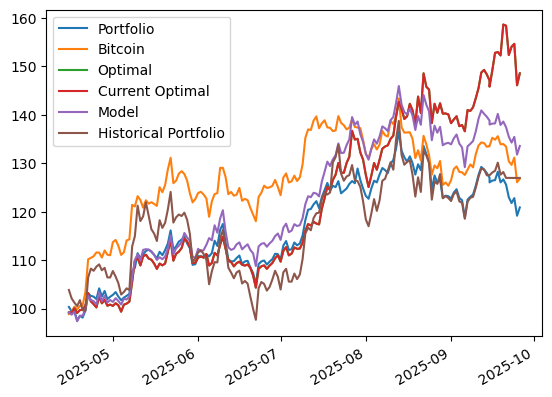

In [86]:
((1+current_perf.loc['2025-04-15':]).cumprod()*100).plot()

<Axes: >

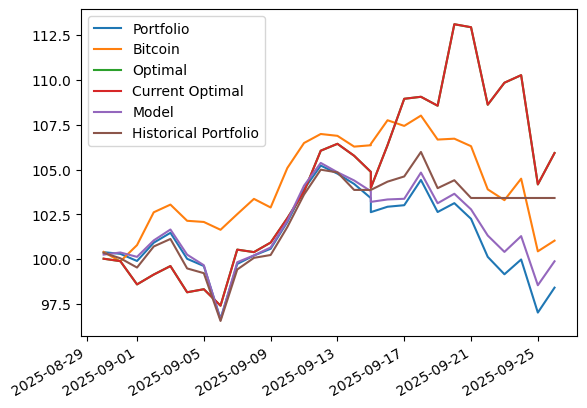

In [87]:
((1+current_perf.loc['2025-08-30':]).cumprod()*100).plot()

In [88]:
((1+current_perf.loc['2025-08-30':]).cumprod()*100)

,Portfolio,Bitcoin,Optimal,Current Optimal,Model,Historical Portfolio
2025-08-30,100.391876,100.404183,100.026959,100.026931,100.256523,100.353789
2025-08-31,100.299979,99.876884,99.891456,99.891265,100.375068,100.051951
2025-09-01,99.900927,100.787165,98.593853,98.593617,100.131022,99.535062
2025-09-02,100.920585,102.618109,99.143162,99.142996,101.048870,100.710311
2025-09-03,101.472401,103.046817,99.617935,99.617710,101.656804,101.129679
2025-09-04,100.021859,102.143595,98.154887,98.154735,100.253501,99.485482
2025-09-05,99.620262,102.078191,98.324561,98.324668,99.663249,99.220782
2025-09-06,96.676020,101.641846,97.406315,97.407374,96.614945,96.554921
2025-09-07,99.733826,102.513832,100.533768,100.534427,99.832474,99.424509
2025-09-08,100.206065,103.366171,100.395026,100.395645,100.211609,100.075140


## Volatilities

In [90]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.277982
 dtype: float64,
 0.2779822585516446)

In [91]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.239828
 dtype: float64,
 0.2398277995084024)

In [92]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.400994
Bitcoin            0.399663
Optimal            0.401900
Current Optimal    0.401896
Model              0.486885
dtype: float64

In [93]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.19607657123972985

In [94]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

-0.14496473082485475

<Axes: >

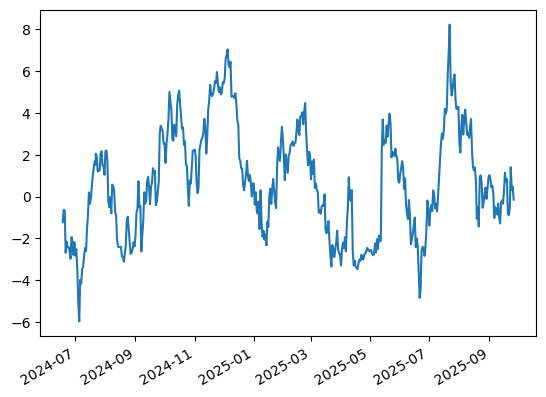

In [95]:
window=30
rolling_sharpe_ratio=current_perf['Historical Portfolio'].rolling(window).mean()*252/(current_perf['Historical Portfolio'].rolling(window).std()*np.sqrt(252))
rolling_sharpe_ratio.plot()

In [96]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

1.056997715831098

## Risk Contribution

In [98]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis.round(4)

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,29.2414,0.7679,0.6540,0.1139
TRXUSDT,8.0588,0.2321,0.1181,0.1139
Portfolio,37.3002,1.0000,0.7721,0.2279


In [99]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,29.248012,0.768101,0.654214,0.113887
TRXUSDT,8.055252,0.231899,0.118011,0.113887
Portfolio,37.303264,1.000000,0.772226,0.227774


In [100]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
TRXUSDT,12.615192,0.549372,0.388912,0.160461
BTCUSDT,1.556222,0.366913,0.194994,0.171918
OMUSDT,-2.194778,0.083715,0.024664,0.059051
Portfolio,11.976636,1.000000,0.608570,0.391430


# Value At Risk

## Historical

### Optimal Weights

In [104]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.04587261813844091, -0.0514633283602446)

### Current Weights

In [106]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.032910667496941104, -0.03962581921103338)

In [107]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [108]:
var=historical_var.iloc[row]
var

TRXUSDT     -0.024457
BTCUSDT     -0.006401
OMUSDT      -0.002727
ETHUSDT     -0.000000
SOLUSDT     -0.000000
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
PAXGUSDT     0.000000
Portfolio   -0.033585
Name: 2025-06-11 00:00:00, dtype: float64

In [109]:
cvar=historical_var.iloc[:row+1].mean()
cvar

TRXUSDT     -0.027083
BTCUSDT     -0.009704
OMUSDT      -0.002840
ETHUSDT      0.000000
SOLUSDT      0.000000
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.039626
dtype: float64

## Parametric

### Optimal Weights

In [112]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.04073722736135764, -0.05045572094007152)

### Current Weights

In [114]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.03514583861233285, -0.04353042020996194)

## Multivariate

### Optimal Weights

In [117]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.0379817851982328, -0.043534069848601635)

### Current Weights

In [119]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.033719914783798946, -0.038986863905108644)

In [120]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

TRXUSDT     -0.017983
BTCUSDT     -0.013053
OMUSDT      -0.002976
Portfolio   -0.034013
dtype: float64

In [121]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

TRXUSDT     -0.019047
BTCUSDT     -0.012593
OMUSDT      -0.002898
Portfolio   -0.034538
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [125]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.03832147505399277, -0.044204075210128375)

### Current Weights

In [127]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.03450675247918691, -0.0390121085392079)

In [128]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [131]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.03823534551890587, -0.04407198887780394)

### Current Weights

In [133]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.03570807842647101, -0.042069357761048636)

In [134]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [137]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.08781764682326555, -0.10658575529177167)

### Current Weights

In [139]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06532703197355293, -0.08120913593459794)

In [140]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [143]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [144]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.04162999567750369, -0.04767247266275251)

### Current Weights

In [146]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.035204442301539955, -0.0403634151638518)

In [147]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [148]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
TRXUSDT,-0.022744,-0.018429,-0.013568,-0.017983,-0.018909
BTCUSDT,-0.016439,-0.012906,-0.009287,-0.013053,-0.013519
OMUSDT,-0.001773,-0.002806,-0.002199,-0.002976,-0.003100
Portfolio,-0.040956,-0.034142,-0.025055,-0.034013,-0.035528


In [149]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
TRXUSDT,-0.022641,-0.019009,-0.013657,-0.019047,-0.019240
BTCUSDT,-0.016550,-0.013044,-0.009483,-0.012593,-0.014164
OMUSDT,-0.002331,-0.002482,-0.002173,-0.002898,-0.002643
Portfolio,-0.041521,-0.034535,-0.025314,-0.034538,-0.036048


## VaR Violation

In [151]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.023169,-0.053130,-0.048552,-0.015037
2024-01-15,-0.023169,-0.054182,-0.046913,0.030718
2024-01-16,-0.023169,-0.053442,-0.046691,-0.006621
2024-01-17,-0.023169,-0.053985,-0.046931,-0.011314
2024-01-18,-0.023169,-0.053059,-0.046879,0.006870
...,...,...,...,...
2025-09-23,-0.044935,-0.044466,-0.042460,0.011292
2025-09-24,-0.031540,-0.038638,-0.035055,0.003842
2025-09-25,-0.050343,-0.044659,-0.042876,-0.055272
2025-09-26,-0.050343,-0.044662,-0.041857,0.016804


In [152]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-15,-0.047061,-0.047914,-0.046057,-0.036553
2023-12-16,-0.047061,-0.047992,-0.043443,0.010582
2023-12-17,-0.047061,-0.048627,-0.046946,-0.013541
2023-12-18,-0.047061,-0.048719,-0.047672,0.007048
2023-12-19,-0.047061,-0.046200,-0.046728,-0.004539
...,...,...,...,...
2025-09-23,-0.020240,-0.027331,-0.027023,-0.009698
2025-09-24,-0.020240,-0.027715,-0.027214,0.008312
2025-09-25,-0.028382,-0.031247,-0.033812,-0.029625
2025-09-26,-0.028382,-0.030404,-0.034703,0.014336


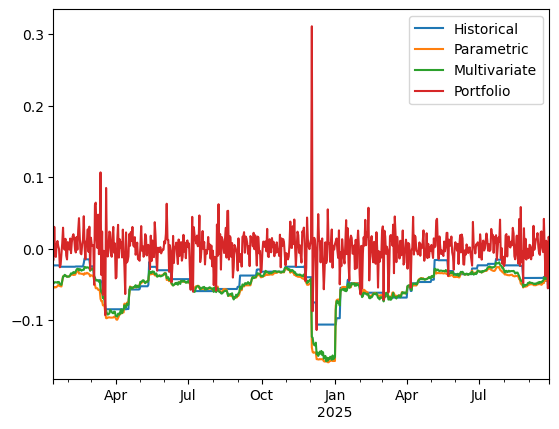

In [153]:
var_data.plot()
plt.show()

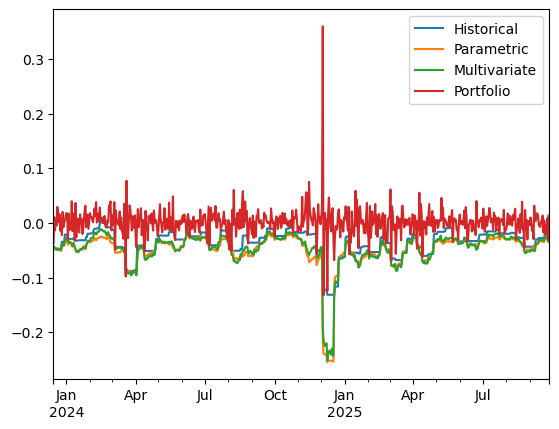

In [154]:
current_var_data.plot()
plt.show()


In [155]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.036918,0.012841,0.012841
Kupiec Stat,2.458996,25.44396,25.44396
P-value,0.116853,0.0,0.0


In [156]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.071975,0.009188,0.01072
Kupiec Stat,5.878993,34.099798,30.787158
P-value,0.015323,0.0,0.0


# Principal Component Analysis

## Historical PCA

In [159]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.8625896 , 0.0427482 , 0.03389392, 0.03243767, 0.02833061])

In [160]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.021308
ADAUSDT      0.019430
ALGOUSDT     0.022967
APTUSDT      0.020134
ARBUSDT      0.029432
ATOMUSDT     0.017859
AVAXUSDT     0.021112
BCHUSDT      0.010718
BNBUSDT      0.009762
BONKUSDT     0.027575
BTCUSDT      0.007484
CAKEUSDT     0.017144
CRVUSDT      0.024155
DOGEUSDT     0.023803
DOTUSDT      0.020089
ETCUSDT      0.019405
ETHUSDT      0.018423
FDUSDUSDT    0.000096
FETUSDT      0.021645
FILUSDT      0.020542
FLOKIUSDT    0.028757
GRTUSDT      0.022132
HBARUSDT     0.021969
ICPUSDT      0.020163
IMXUSDT      0.028301
INJUSDT      0.027077
LDOUSDT      0.027632
LINKUSDT     0.023149
LTCUSDT      0.015070
NEARUSDT     0.024072
NEXOUSDT     0.007720
OMUSDT       0.023849
OPUSDT       0.027599
PAXGUSDT    -0.000172
PEPEUSDT     0.025824
QNTUSDT      0.015786
RAYUSDT      0.024457
SEIUSDT      0.025695
SHIBUSDT     0.018465
SOLUSDT      0.019747
STXUSDT      0.022225
SUIUSDT      0.023850
TRXUSDT      0.005504
UNIUSDT      0.023935
USDCUSDT    -0.000015
VETUSDT   

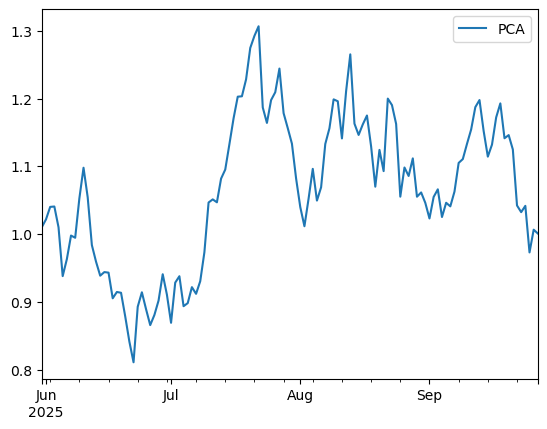

In [161]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

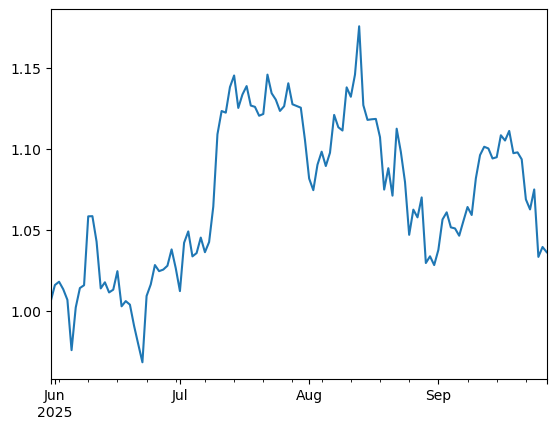

In [162]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [163]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
DOTUSDT      0.124043
SHIBUSDT     0.124379
VETUSDT      0.134744
FILUSDT      0.136586
ATOMUSDT     0.141110
GRTUSDT      0.149176
ICPUSDT      0.155497
NEARUSDT     0.165340
ADAUSDT      0.181684
PEPEUSDT     0.182167
ETHUSDT      0.185877
WBETHUSDT    0.185994
APTUSDT      0.188507
STXUSDT      0.193555
DOGEUSDT     0.196378
FETUSDT      0.196487
ETCUSDT      0.197921
SOLUSDT      0.199573
INJUSDT      0.215176
dtype: float64

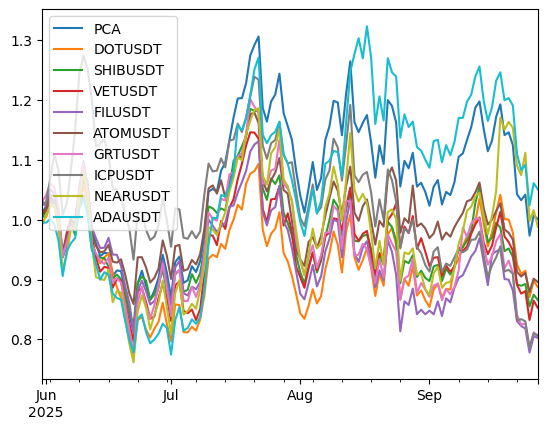

In [164]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

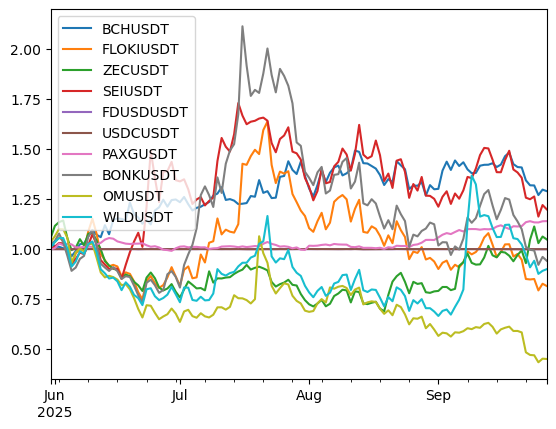

In [165]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [167]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.75619906, 0.15908579, 0.03757516, 0.02532375, 0.02181625])

In [168]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

TRXUSDT     0.042428
BTCUSDT     0.060718
OMUSDT      0.266149
ETHUSDT     0.158016
SOLUSDT     0.167477
BNBUSDT     0.085911
PEPEUSDT    0.221274
PAXGUSDT   -0.001975
Name: PC1, dtype: float64

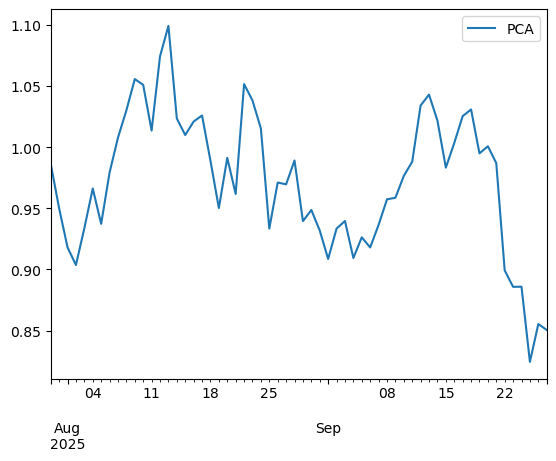

In [169]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA.iloc[-60:]).cumprod().plot()
plt.show()

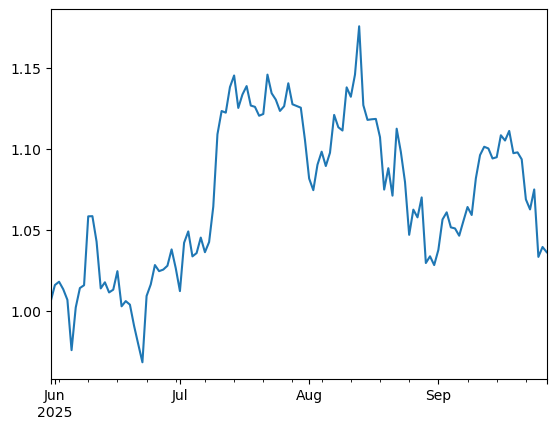

In [170]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [171]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA         0.000000
ETHUSDT     0.199334
PEPEUSDT    0.211603
SOLUSDT     0.221433
BNBUSDT     0.259966
BTCUSDT     0.285691
TRXUSDT     0.348236
OMUSDT      0.368607
PAXGUSDT    0.402767
dtype: float64

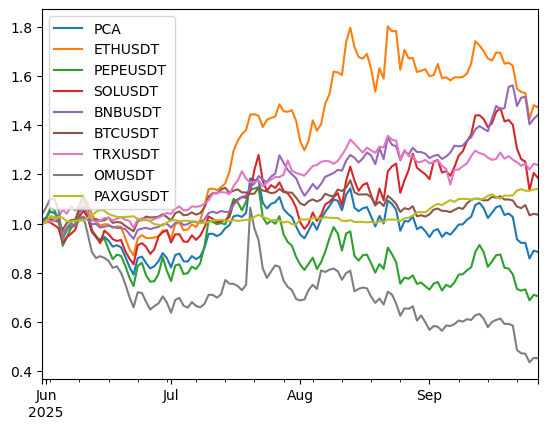

In [172]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [174]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT    1.925044
SOLUSDT     1.307381
ETHUSDT     1.113302
OMUSDT      1.025324
BTCUSDT     1.000000
BNBUSDT     0.677665
TRXUSDT     0.343310
PAXGUSDT    0.028572
Name: BTCUSDT, dtype: float64

In [175]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

OMUSDT      2.317108
SOLUSDT     2.047739
PEPEUSDT    1.808503
ETHUSDT     1.275464
BNBUSDT     1.068574
BTCUSDT     1.000000
TRXUSDT     0.651834
PAXGUSDT   -0.106506
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [177]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [178]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
PEPEUSDT,0.362278
BTCUSDT,0.299668
SOLUSDT,0.220582
OMUSDT,0.121411
BNBUSDT,0.058707
TRXUSDT,0.006130
ETHUSDT,-0.010381
PAXGUSDT,-0.160326


### Regression to PCA

In [180]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.3455995546926756

In [181]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

PCA         1.000000
ETHUSDT     0.901146
BNBUSDT     0.810525
BTCUSDT     0.751188
SOLUSDT     0.616056
PEPEUSDT    0.316764
TRXUSDT     0.268861
OMUSDT      0.140852
PAXGUSDT   -0.146416
dtype: float64

In [182]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT     1.761421
ETHUSDT     1.028950
PCA         1.000000
TRXUSDT     0.903192
BNBUSDT     0.862354
SOLUSDT     0.779665
PEPEUSDT    0.778855
OMUSDT      0.602524
PAXGUSDT   -1.453231
dtype: float64

### Correlation Matrix

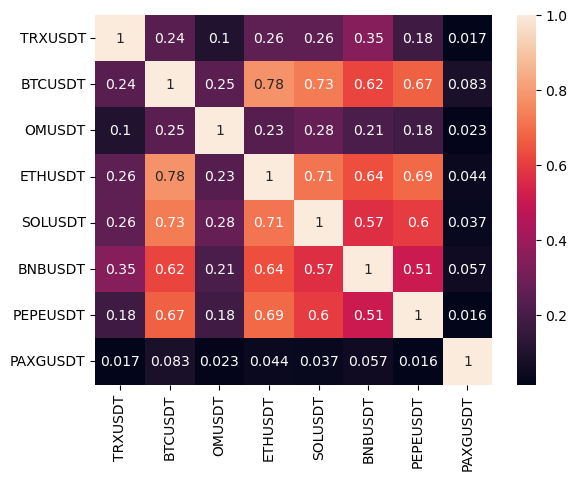

In [184]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

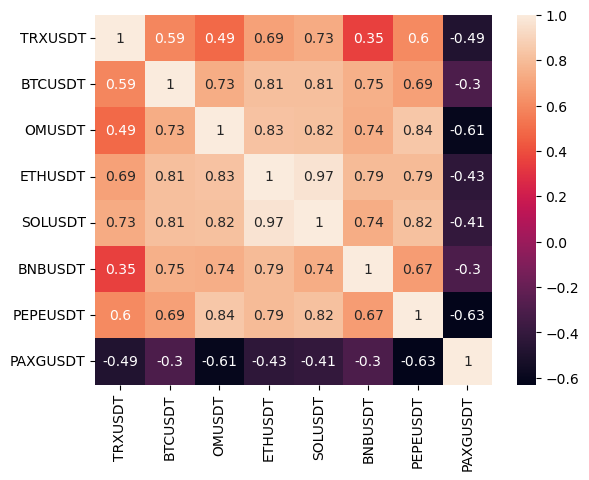

In [185]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [186]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [187]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

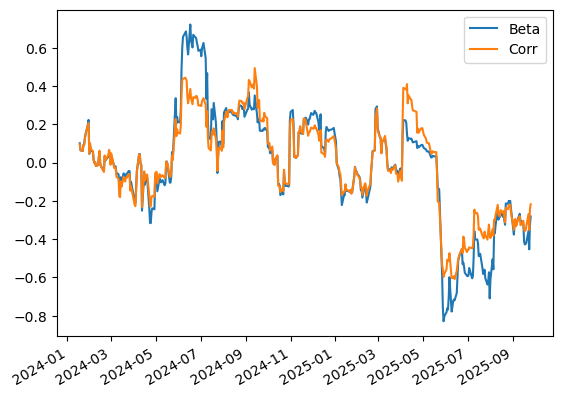

In [188]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [190]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,TRXUSDT,BTCUSDT,OMUSDT,ETHUSDT,SOLUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2023-12-14,0.000000,0.107613,0.104338,0.000000,0.000000,0.522522,0.000000,0.265527
2023-12-28,0.000000,0.000000,0.000000,0.000000,0.331762,0.668238,0.000000,0.000000
2024-01-11,0.000000,0.000000,0.560261,0.439739,0.000000,0.000000,0.000000,0.000000
2024-01-25,0.379492,0.000000,0.104622,0.000000,0.000000,0.000000,0.000000,0.515886
2024-02-08,0.066364,0.000000,0.047113,0.191144,0.041760,0.000000,0.000000,0.653620
2024-02-22,0.705974,0.000000,0.000000,0.164223,0.000000,0.129803,0.000000,0.000000
2024-03-07,0.000000,0.000000,0.000000,0.020832,0.156080,0.000000,0.046602,0.776486
2024-03-21,0.000000,0.000000,0.462471,0.000000,0.000000,0.471815,0.065714,0.000000
2024-04-04,0.000000,0.000920,0.019296,0.000000,0.000000,0.113904,0.000000,0.865879
2024-04-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [191]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

In [192]:
for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit[0]]-0.0},
                                                                    {'type': 'eq', 'fun': lambda weights: weights[limit[1]]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,ZECUSDT
2025-02-19,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2025-03-21,0.000000,0.986079,0.013838,0.0,0.0,0.0,0.000000,0.000083,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2025-04-20,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.071596,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2025-05-20,0.244983,0.000000,0.026705,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.135113,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.186675
2025-06-19,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.902745,0.000000,0.000000,...,0.000000,0.097255,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2025-07-19,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.157494,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.102116,0.408491,0.000000
2025-08-18,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.353267,0.000000,...,0.564894,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2025-09-17,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.141855,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.064243,0.000000,0.000000,0.464950
2025-09-27,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.993526


In [193]:
rolling_optimization.iloc[-2].sort_values(ascending=False)[:6]

ZECUSDT     0.464950
SOLUSDT     0.328952
AVAXUSDT    0.141855
WLDUSDT     0.064243
NEARUSDT    0.000000
NEXOUSDT    0.000000
Name: 2025-09-17 00:00:00, dtype: float64

In [194]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
